In [1]:
import psutil
import gc
import os
import pandas as pd
import numpy as np

from tqdm import tqdm

import torch
from torch.utils import data
import time

from PIL import Image
import matplotlib.pyplot as plt

In [2]:
data_path = '/scratch/users/neuroimage/conda/data/preprocessed/imgsss'
meta_data_path = '/scratch/users/neuroimage/conda/data/ADNI1_Complete_2Yr_3T_4_18_2023.csv'
model_dir = '/scratch/users/neuroimage/conda/data/models'

# Preprocessing

In [77]:
import io
import nibabel as nib
from io import BytesIO
# import matplotlib.pyplot as plt
import nilearn as nil # https://nilearn.github.io/stable/quickstart.html
from nilearn import plotting

In [78]:
df = pd.read_csv(meta_data_path)
df.head()

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I205567,136_S_1227,MCI,F,66,m18,MRI,MPR; ; N3; Scaled,Processed,9/29/2008,NiFTI,4/12/2023
1,I66824,136_S_1227,MCI,F,65,bl,MRI,MPR; ; N3; Scaled,Processed,2/21/2007,NiFTI,4/12/2023
2,I79080,136_S_1227,MCI,F,65,m06,MRI,MPR; ; N3; Scaled,Processed,9/11/2007,NiFTI,4/12/2023
3,I143856,136_S_1227,MCI,F,67,m24,MRI,MPR; ; N3; Scaled,Processed,3/23/2009,NiFTI,4/12/2023
4,I99265,136_S_1227,MCI,F,66,m12,MRI,MPR; ; N3; Scaled,Processed,3/06/2008,NiFTI,4/12/2023


In [79]:
df_new = df[['Image Data ID', 'Subject', 'Group']].set_index(df[['Image Data ID', 'Subject', 'Group']].apply(lambda x: (x['Image Data ID'], x['Subject']), axis=1))
df_new.head()

,Image Data ID,Subject,Group
"(I205567, 136_S_1227)",I205567,136_S_1227,MCI
"(I66824, 136_S_1227)",I66824,136_S_1227,MCI
"(I79080, 136_S_1227)",I79080,136_S_1227,MCI
"(I143856, 136_S_1227)",I143856,136_S_1227,MCI
"(I99265, 136_S_1227)",I99265,136_S_1227,MCI


In [80]:
# random shuffle
np.random.seed(0)
random_index = np.random.permutation(df_new.index)
df_new = df_new.loc[random_index]

In [81]:
df_new.shape

(434, 3)

In [82]:
df_dict = df_new['Group'].to_dict()
# df_dict

In [83]:
# train-test-split here, 70%, 10%, 20%
df_len = len(df_new)
train_test_assign = ["train"] * round(0.7*df_len) + ["val"] * (round(0.8*df_len) - round(0.7*df_len)) + ["test"] * (df_len - round(0.8*df_len))
df_new['train_test_assign'] = train_test_assign
df_train_test_dict = df_new['train_test_assign'].to_dict()

In [28]:

# train-test-split here, 70%, 10%, 20%
# df_len = len(df_new)
# df_train = df_new[:round(0.7*df_len)]
# df_val = df_new[round(0.7*df_len):round(0.8*df_len)]
# df_test = df_new[round(0.8*df_len):]

(121, 145, 121)
smt-031_S_1066-I90916-gm.nii.gz
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


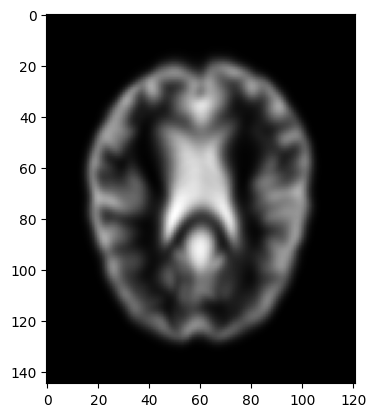

In [84]:
# generate plot
for filename in os.listdir(data_path):
    file_path = os.path.join(data_path, filename)
    if os.path.isfile(file_path) and filename.endswith('nii.gz') and filename.startswith('smt'):
        split_str = filename.split('-')
        # print(split_str)
        img_id = split_str[2]
        subject = split_str[1]
        assert (img_id, subject) in df_dict
        class_name = df_dict[(img_id, subject)]
        # print(type(category))
        # print(os.path.join(data_path, filename))
        img = nib.load(os.path.join(data_path, filename))
        # print(img)
        
        data = img.get_fdata()
        print(data.shape)
        print(filename)
        plt.imshow(data[60,:,:], cmap='gray')
        print(data[60,:,:])
        # for i in range(120):
        #     plt.imshow(data[:,:,i], cmap='gray')
        #     plt.show()
        break


In [85]:
sample = data[60,:,:]
sample.shape

(145, 121)

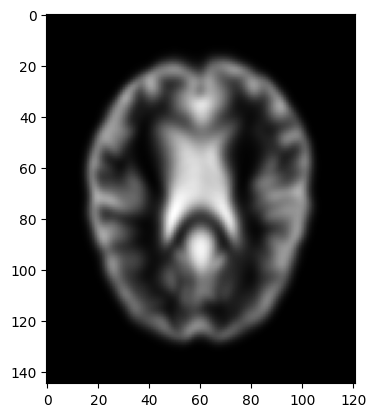

In [99]:
elastic_transform = transforms.ElasticTransform(alpha=50.0, sigma=10.0)
img = Image.fromarray(sample)
augmented_image = elastic_transform(img)
plt.imshow(np.array(augmented_image), cmap = 'gray')

## 1. generate 2D

In [86]:
def generate_dataset_2D(out_dir):
    # pair the image with labels and put them into respective folder for gm and wm, generate all the 2-D images
    
    for filename in os.listdir(data_path):
        file_path = os.path.join(data_path, filename)
        if os.path.isfile(file_path) and filename.endswith('nii.gz') and filename.startswith('smt'):
            split_str = filename.split('-')
            # print(split_str)
            img_id = split_str[2]
            subject = split_str[1]
            assert (img_id, subject) in df_dict
            class_name = df_dict[(img_id, subject)]
            # print(type(category))
            # print(os.path.join(data_path, filename))
            img = nib.load(os.path.join(data_path, filename))
            # print(img)
            
            data = img.get_fdata()
            
            z_shape = data.shape[0]
            
            i = z_shape // 2
            np_array = data[i,:,:]
            # plt.imshow(np_array, cmap='gray')
            # print(i, np_array)
            img = Image.fromarray(np_array)
            # plt.imshow(np.array(img), cmap='gray')
            # plt.show()
            folder_name = filename.split('.')[0]
            filename_new = folder_name + f'_{str(i)}.tiff'
            # print(filename, filename_new)
            gm_wm = filename.split('.')[0].split('-')[-1]
            # print(os.path.join(out_dir, gm_wm, class_name, folder_name, filename_new))
            train_test = df_train_test_dict[(img_id, subject)]
            if not os.path.exists(os.path.join(out_dir, train_test, gm_wm, class_name, folder_name)):
                os.makedirs(os.path.join(out_dir, train_test, gm_wm, class_name, folder_name))
            # print(os.path.join(out_dir, train_test, gm_wm, class_name, folder_name))
            # np.save(os.path.join(out_dir,train_test, gm_wm, class_name, folder_name, filename_new), np_array)
            img.save(os.path.join(out_dir,train_test, gm_wm, class_name, folder_name, filename_new))

            # for i in range(z_shape):
            #     np_array = data[i,:,:]
            #     img = Image.fromarray(np.uint8(np_array))
            #     folder_name = filename.split('.')[0]
            #     filename_new = folder_name + f'_{str(i)}.jpg'
            #     # print(filename, filename_new)
            #     gm_wm = filename.split('.')[0].split('-')[-1]
            #     # print(os.path.join(out_dir, gm_wm, class_name, folder_name, filename_new))
            #     if not os.path.exists(os.path.join(out_dir, gm_wm, class_name, folder_name)):
            #         os.makedirs(os.path.join(out_dir, gm_wm, class_name, folder_name))
            #     # print(os.path.join(out_dir, class_name, filename_new)) 
            #     img.save(os.path.join(out_dir, gm_wm, class_name, folder_name, filename_new))
            print('finish', filename_new)


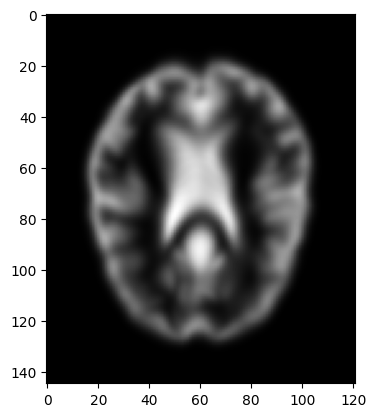

In [87]:
# pair the image with labels and put them into respective folder for gm and wm, generate all the 2-D images
out_dir_single = '/scratch/users/neuroimage/conda/data/paired_data/2D_single'
generate_dataset_2D(out_dir_single)

In [ ]:
# sample
filename = 'pp-051_S_1331-I82509-gm.nii.gz'
img = nib.load(os.path.join(data_path, filename))

data = img.get_fdata()

## 2. Preprocess 3D

In [62]:
def generate_dataset_2D_multiple(out_dir):
    # pair the image with labels and put them into respective folder for gm and wm, generate all the 2-D images
    
    for filename in os.listdir(data_path):
        file_path = os.path.join(data_path, filename)
        if os.path.isfile(file_path) and filename.endswith('nii.gz') and filename.startswith('smt'):
            split_str = filename.split('-')
            # print(split_str)
            img_id = split_str[2]
            subject = split_str[1]
            assert (img_id, subject) in df_dict
            class_name = df_dict[(img_id, subject)]
            # print(type(category))
            # print(os.path.join(data_path, filename))
            img = nib.load(os.path.join(data_path, filename))
            # print(img)
            
            data = img.get_fdata()
            
            z_shape = data.shape[0]
            
            for i in range(z_shape):
                np_array = data[i,:,:]
                non_zero_count = np.count_nonzero(np_array)
                zero_count = np_array.size - non_zero_count
                print(i, non_zero_count / np_array.size)
                # if i == 40 or i == 80:
                #     img = Image.fromarray(np_array)
                #     plt.imshow(np.array(img), cmap='gray')
                #     plt.show()
                continue
                img = Image.fromarray(np_array)
                folder_name = filename.split('.')[0]
                
                

                filename_new = folder_name + f'_{str(i)}.jpg'
                # print(filename, filename_new)
                gm_wm = filename.split('.')[0].split('-')[-1]
                # print(os.path.join(out_dir, gm_wm, class_name, folder_name, filename_new))
                if not os.path.exists(os.path.join(out_dir, gm_wm, class_name, folder_name)):
                    os.makedirs(os.path.join(out_dir, gm_wm, class_name, folder_name))
                # print(os.path.join(out_dir, class_name, filename_new)) 
                img.save(os.path.join(out_dir, gm_wm, class_name, folder_name, filename_new))
            # print('finish', filename_new)
            break
out_dir_mul = '/scratch/users/neuroimage/conda/data/paired_data/2D_mul'
generate_dataset_2D_multiple(out_dir_mul)

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0002279851809632374
10 0.0018808777429467085
11 0.015161014534055287
12 0.04109432886862354
13 0.05939013964092334
14 0.07700199487033343
15 0.09723567968082075
16 0.11718438301510402
17 0.13559418637788545
18 0.15457395269307495
19 0.171900826446281
20 0.1883157594756341
21 0.20381875178113423
22 0.22034767740096894
23 0.2358506697064691
24 0.25317754345967514
25 0.27153035052721575
26 0.28805927614705046
27 0.30504417212881163
28 0.3225990310629809
29 0.33639213451125677
30 0.3494442861214021
31 0.3634653747506412
32 0.3760045597036193
33 0.3870618409803363
34 0.3986320889142206
35 0.4102593331433457
36 0.4261043032202907
37 0.4380165289256198
38 0.45095468794528354
39 0.4608150470219436
40 0.4695924764890282
41 0.4791108577942434
42 0.48503847249928755
43 0.4936449130806498
44 0.5011114277571957
45 0.5077799943003705
46 0.5173553719008265
47 0.5251068680535765
48 0.5345682530635508
49 0.5408948418352807
50 0.548874323168994
5

In [28]:
def calculate_nonzero_percentage():
    # pair the image with labels and put them into respective folder for gm and wm, generate all the 2-D images
    large_lst = []
    for filename in os.listdir(data_path):
        file_path = os.path.join(data_path, filename)
        if os.path.isfile(file_path) and filename.endswith('nii.gz') and filename.startswith('smt'):
            # split_str = filename.split('-')
            # # print(split_str)
            # img_id = split_str[2]
            # subject = split_str[1]
            # assert (img_id, subject) in df_dict
            # class_name = df_dict[(img_id, subject)]
            # print(type(category))
            # print(os.path.join(data_path, filename))
            img = nib.load(os.path.join(data_path, filename))
            # print(img)
            
            data = img.get_fdata()
            
            z_shape = data.shape[0]
            
            lst = []
            for i in range(z_shape):
                np_array = data[i,:,:]
                non_zero_count = np.count_nonzero(np_array)
                lst.append(non_zero_count / np_array.size)
            large_lst.append(lst)
            print("finish")
    return np.array(large_lst)
            

non_zero_count_arr = calculate_nonzero_percentage()

finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish

In [30]:
np.save("non_zero_count_arr.npy", non_zero_count_arr)

In [29]:
non_zero_count_arr.shape

(868, 121)

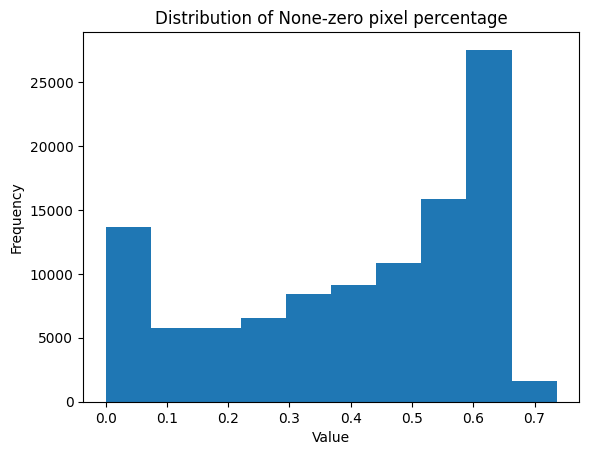

In [31]:
arr_flat = non_zero_count_arr.flatten()

plt.hist(arr_flat)

plt.title("Distribution of None-zero pixel percentage")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.show()

In [36]:
non_zero_val = np.count_nonzero(arr_flat)
print(non_zero_val, non_zero_val/non_zero_count_arr.size)

96545 0.919231062192939


In [39]:
valid_val =(arr_flat > 0.1).sum()
print(valid_val, valid_val/non_zero_count_arr.size)

89228 0.8495639258102601


In [64]:
def generate_dataset_2D_mul(out_dir):
    # pair the image with labels and put them into respective folder for gm and wm, generate all the 2-D images
    
    for filename in os.listdir(data_path):
        file_path = os.path.join(data_path, filename)
        if os.path.isfile(file_path) and filename.endswith('nii.gz') and filename.startswith('smt'):
            split_str = filename.split('-')
            # print(split_str)
            img_id = split_str[2]
            subject = split_str[1]
            assert (img_id, subject) in df_dict
            class_name = df_dict[(img_id, subject)]
            # print(type(category))
            # print(os.path.join(data_path, filename))
            img = nib.load(os.path.join(data_path, filename))
            # print(img)
            
            data = img.get_fdata()
            
            z_shape = data.shape[0]
            
            for i in range(40,80):
                np_array = data[i,:,:]
                # plt.imshow(np_array, cmap='gray')
                # print(i, np_array)
                img = Image.fromarray(np_array)
                # plt.imshow(np.array(img), cmap='gray')
                # plt.show()
                folder_name = filename.split('.')[0]
                filename_new = folder_name + f'_{str(i)}.tiff'
                # print(filename, filename_new)
                gm_wm = filename.split('.')[0].split('-')[-1]
                # print(os.path.join(out_dir, gm_wm, class_name, folder_name, filename_new))
                train_test = df_train_test_dict[(img_id, subject)]
                if not os.path.exists(os.path.join(out_dir, train_test, gm_wm, class_name, folder_name)):
                    os.makedirs(os.path.join(out_dir, train_test, gm_wm, class_name, folder_name))
                # print(os.path.join(out_dir, train_test, gm_wm, class_name, folder_name))
                # np.save(os.path.join(out_dir,train_test, gm_wm, class_name, folder_name, filename_new), np_array)
                img.save(os.path.join(out_dir,train_test, gm_wm, class_name, folder_name, filename_new))

            # for i in range(z_shape):
            #     np_array = data[i,:,:]
            #     img = Image.fromarray(np.uint8(np_array))
            #     folder_name = filename.split('.')[0]
            #     filename_new = folder_name + f'_{str(i)}.jpg'
            #     # print(filename, filename_new)
            #     gm_wm = filename.split('.')[0].split('-')[-1]
            #     # print(os.path.join(out_dir, gm_wm, class_name, folder_name, filename_new))
            #     if not os.path.exists(os.path.join(out_dir, gm_wm, class_name, folder_name)):
            #         os.makedirs(os.path.join(out_dir, gm_wm, class_name, folder_name))
            #     # print(os.path.join(out_dir, class_name, filename_new)) 
            #     img.save(os.path.join(out_dir, gm_wm, class_name, folder_name, filename_new))
            print('finish', filename)
out_dir_mul = '/scratch/users/neuroimage/conda/data/paired_data/2D_mul'
generate_dataset_2D_mul(out_dir_mul)

finish smt-031_S_1066-I90916-gm.nii.gz
finish smt-130_S_0886-I65514-wm.nii.gz
finish smt-027_S_0307-I83030-wm.nii.gz
finish smt-136_S_0426-I120441-gm.nii.gz
finish smt-136_S_0086-I67781-gm.nii.gz
finish smt-016_S_1121-I120392-wm.nii.gz
finish smt-067_S_0607-I89123-wm.nii.gz
finish smt-023_S_1046-I87518-wm.nii.gz
finish smt-100_S_0015-I63475-wm.nii.gz
finish smt-116_S_1249-I80700-gm.nii.gz
finish smt-002_S_0559-I118679-gm.nii.gz
finish smt-023_S_0916-I64827-wm.nii.gz
finish smt-005_S_0572-I120460-gm.nii.gz
finish smt-037_S_0303-I105924-wm.nii.gz
finish smt-136_S_0426-I40378-wm.nii.gz
finish smt-031_S_0830-I102502-wm.nii.gz
finish smt-023_S_0058-I118837-wm.nii.gz
finish smt-002_S_1018-I97022-gm.nii.gz
finish smt-016_S_1121-I96239-wm.nii.gz
finish smt-027_S_0404-I47545-gm.nii.gz
finish smt-051_S_1123-I58054-wm.nii.gz
finish smt-023_S_0926-I64995-wm.nii.gz
finish smt-002_S_1268-I92226-gm.nii.gz
finish smt-023_S_0030-I118835-gm.nii.gz
finish smt-023_S_0388-I118871-gm.nii.gz
finish smt-023_S

# Model and Analysis

In [3]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models

In [4]:
from torchvision import datasets, transforms
def tiff_loader(path: str) -> Image.Image:
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, "rb") as f:
        img = Image.open(f)
        # print(np.array(img).shape)
        # plt.imshow(np.array(img),cmap='gray')
        # plt.show()
        img.load()
        
        return img # .convert('RGB')

In [5]:
import random
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
RANDOM_SEED = 123
NUM_EPOCHS = 50
DEVICE = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
set_all_seeds(RANDOM_SEED)

In [6]:
# helper function
from itertools import product
def compute_accuracy(model, data_loader, device, repeat = False):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):
            # print(features[0,:,:,:].transpose(0,1).transpose(1,2).shape)
            # plt.imshow(features[0,:,:,:].transpose(0,1).transpose(1,2))
            # plt.show()
            if repeat:
                features = features.repeat(1,3,1,1)
            features = features.to(device)
            # torch.set_printoptions(precision=3)
            # torch.set_printoptions(threshold=float("inf"))
            
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            # print(a, predicted_labels)
            # print(targets, predicted_labels)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
# feat = compute_accuracy(model, train_loader, DEVICE)
# print(compute_accuracy(model, val_loader, DEVICE))

## Model 1. simple resnet 18/50

In [7]:
batch_size = 31

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomResizedCrop(224),
    # transforms.ColorJitter(contrast=0.4),
    transforms.ElasticTransform(alpha=70.0, sigma=7.0),
    transforms.ToTensor(),
    transforms.Normalize([0.2170], [0.2997])  # wm
    # transforms.Normalize([0.1690], [0.2304]) # gm
])
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.2170], [0.2997])  # wm
    # transforms.Normalize([0.1690], [0.2304]) # gm
])

out_dir_single = '/scratch/users/neuroimage/conda/data/paired_data/2D_single'
train_path = os.path.join(out_dir_single, 'train', 'wm')
train_dataset = datasets.ImageFolder(train_path, transform=train_transform, loader=tiff_loader)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

val_path = os.path.join(out_dir_single, 'val', 'wm')
val_dataset = datasets.ImageFolder(val_path, transform=test_transform, loader=tiff_loader)
val_loader = torch.utils.data.DataLoader(val_dataset,  shuffle=True)

test_path = os.path.join(out_dir_single, 'test', 'wm')
test_dataset = datasets.ImageFolder(test_path, transform=test_transform, loader=tiff_loader)
test_loader = torch.utils.data.DataLoader(test_dataset,  shuffle=True)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset.imgs), shuffle=False, num_workers=1)

for data in train_loader:
    pixels = data[0]
    # pixels.append(data[0].squeeze())


mean = torch.mean(pixels, dim=(0, 2, 3))
std = torch.std(pixels, dim=(0, 2, 3))

print('Mean:', mean)
print('Std:', std)

Mean: tensor([-9.1694e-05])
Std: tensor([1.0000])


Define the model

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# resnet
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes), bias=True)

# path = model_dir + "/resnet50_wd0.001_normalize/resnet50_05012343/resnet50_05012343_epoch32.pth"
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
path = "/scratch/users/neuroimage/conda/data/models/resnet50_wd0.001_normalize_layer34_lr0.0005_aug/resnet50_05030801/resnet50_05030801_epoch4.pth"
model.load_state_dict(torch.load(path))
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
conv1_weight = model.state_dict()['conv1.weight']
conv1_weight_agg = conv1_weight.sum(axis=1, keepdim=True)
conv1_weight_agg.shape

torch.Size([64, 1, 7, 7])

In [9]:
for name, param in model.named_parameters():
    if 'layer4' in name or 'layer3' in name or 'layer2' in name:
        param.requires_grad = True 
    elif 'fc' in name:
        param.requires_grad = True 
    else:
        param.requires_grad = False

In [37]:
model.fc.requires_grad = True

In [26]:
model.conv1.weight.data = conv1_weight_agg

In [10]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()
def train_model(model, num_epochs, train_loader,
                valid_loader, test_loader, optimizer,
                device, logging_interval=50,
                scheduler=None,
                scheduler_on='valid_acc', model_path = None, save_interval = 10, timestamp = None):

    start_time = time.time()
    minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []
    
    for epoch in tqdm(range(num_epochs)):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):
            # features = features.repeat(1,3,1,1).to(device)
            features = features.to(device)
            targets = targets.to(device)

            # ## FORWARD AND BACK PROP
            logits = model(features)
            loss = torch.nn.functional.cross_entropy(logits, targets)
            optimizer.zero_grad()

            loss.backward()

            # ## UPDATE MODEL PARAMETERS
            optimizer.step()
            # print(model.fc.weight.grad)

            # ## LOGGING
            minibatch_loss_list.append(loss.item())
            if not batch_idx % logging_interval:
                print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                      f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                      f'| Loss: {loss:.4f}')

        model.eval()
        with torch.no_grad():  # save memory during inference
            train_acc = compute_accuracy(model, train_loader, device=device)
            valid_acc = compute_accuracy(model, valid_loader, device=device)
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                  f'| Train: {train_acc :.2f}% '
                  f'| Validation: {valid_acc :.2f}%')
            train_acc_list.append(train_acc.item())
            valid_acc_list.append(valid_acc.item())

        elapsed = (time.time() - start_time)/60
        print(f'Time elapsed: {elapsed:.2f} min')
        
        if scheduler is not None:

            if scheduler_on == 'valid_acc':
                scheduler.step(valid_acc_list[-1])
            elif scheduler_on == 'minibatch_loss':
                scheduler.step(minibatch_loss_list[-1])
            else:
                raise ValueError(f'Invalid `scheduler_on` choice.')
        
        if epoch % save_interval == 0:
            model_prefix = "resnet50"
            model_name = f"{model_prefix}_{timestamp}_epoch{epoch}.pth"
            torch.save(model.state_dict(), os.path.join(model_path, model_name))
            
            test_acc = compute_accuracy(model, test_loader, device=device)
            print(f'Test accuracy {test_acc :.2f}%')
            

    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')

    test_acc = compute_accuracy(model, test_loader, device=device)
    print(f'Test accuracy {test_acc :.2f}%')

    return minibatch_loss_list, train_acc_list, valid_acc_list

In [126]:
import copy
model = copy.deepcopy(model4)

In [11]:
optimizer = optim.Adam(model.parameters(), lr=0.0002, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.2,
                                                       mode='max',
                                                       verbose=True, patience=8)

NUM_EPOCHS = 50
model_prefix = "resnet50"

from datetime import datetime
timestamp = datetime.now().strftime("%m%d%H%M")
model_name_path = f"{model_prefix}_{timestamp}"
model_path = os.path.join(model_dir, model_prefix + '_wd0.001_normalize_layer234_lr0.0002_aug_alpha70_sigma7', model_name_path)

if not os.path.exists(model_path):
    os.makedirs(model_path)


minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=val_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=1,  model_path = model_path, save_interval = 1, timestamp = timestamp)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 001/050 | Batch 0000/0010 | Loss: 0.0902
Epoch: 001/050 | Batch 0001/0010 | Loss: 0.2066
Epoch: 001/050 | Batch 0002/0010 | Loss: 0.3315
Epoch: 001/050 | Batch 0003/0010 | Loss: 0.1659
Epoch: 001/050 | Batch 0004/0010 | Loss: 0.1941
Epoch: 001/050 | Batch 0005/0010 | Loss: 0.3094
Epoch: 001/050 | Batch 0006/0010 | Loss: 0.4534
Epoch: 001/050 | Batch 0007/0010 | Loss: 0.1247
Epoch: 001/050 | Batch 0008/0010 | Loss: 0.1972
Epoch: 001/050 | Batch 0009/0010 | Loss: 0.2061
Epoch: 001/050 | Train: 90.79% | Validation: 81.40%
Time elapsed: 3.67 min


  2%|▏         | 1/50 [03:52<3:09:33, 232.11s/it]

Test accuracy 91.95%
Epoch: 002/050 | Batch 0000/0010 | Loss: 0.3653
Epoch: 002/050 | Batch 0001/0010 | Loss: 0.1835
Epoch: 002/050 | Batch 0002/0010 | Loss: 0.2461
Epoch: 002/050 | Batch 0003/0010 | Loss: 0.3323
Epoch: 002/050 | Batch 0004/0010 | Loss: 0.2666
Epoch: 002/050 | Batch 0005/0010 | Loss: 0.3549
Epoch: 002/050 | Batch 0006/0010 | Loss: 0.4395
Epoch: 002/050 | Batch 0007/0010 | Loss: 0.5977
Epoch: 002/050 | Batch 0008/0010 | Loss: 0.3917
Epoch: 002/050 | Batch 0009/0010 | Loss: 0.4863
Epoch: 002/050 | Train: 85.20% | Validation: 90.70%
Time elapsed: 8.08 min


  4%|▍         | 2/50 [08:15<3:20:35, 250.74s/it]

Test accuracy 83.91%
Epoch: 003/050 | Batch 0000/0010 | Loss: 0.2351
Epoch: 003/050 | Batch 0001/0010 | Loss: 0.4844
Epoch: 003/050 | Batch 0002/0010 | Loss: 0.2895
Epoch: 003/050 | Batch 0003/0010 | Loss: 0.2349
Epoch: 003/050 | Batch 0004/0010 | Loss: 0.2433
Epoch: 003/050 | Batch 0005/0010 | Loss: 0.2120
Epoch: 003/050 | Batch 0006/0010 | Loss: 0.2121
Epoch: 003/050 | Batch 0007/0010 | Loss: 0.2210
Epoch: 003/050 | Batch 0008/0010 | Loss: 0.1269
Epoch: 003/050 | Batch 0009/0010 | Loss: 0.3012
Epoch: 003/050 | Train: 88.16% | Validation: 67.44%
Time elapsed: 12.55 min


  6%|▌         | 3/50 [12:44<3:22:42, 258.78s/it]

Test accuracy 81.61%
Epoch: 004/050 | Batch 0000/0010 | Loss: 0.5209
Epoch: 004/050 | Batch 0001/0010 | Loss: 0.2202
Epoch: 004/050 | Batch 0002/0010 | Loss: 0.5083
Epoch: 004/050 | Batch 0003/0010 | Loss: 0.1607
Epoch: 004/050 | Batch 0004/0010 | Loss: 0.3626
Epoch: 004/050 | Batch 0005/0010 | Loss: 0.2117
Epoch: 004/050 | Batch 0006/0010 | Loss: 0.1863
Epoch: 004/050 | Batch 0007/0010 | Loss: 0.1541
Epoch: 004/050 | Batch 0008/0010 | Loss: 0.3574
Epoch: 004/050 | Batch 0009/0010 | Loss: 0.2450
Epoch: 004/050 | Train: 89.47% | Validation: 81.40%
Time elapsed: 16.92 min


  8%|▊         | 4/50 [17:09<3:20:15, 261.21s/it]

Test accuracy 86.21%
Epoch: 005/050 | Batch 0000/0010 | Loss: 0.2023
Epoch: 005/050 | Batch 0001/0010 | Loss: 0.1865
Epoch: 005/050 | Batch 0002/0010 | Loss: 0.3027
Epoch: 005/050 | Batch 0003/0010 | Loss: 0.1902
Epoch: 005/050 | Batch 0004/0010 | Loss: 0.1637
Epoch: 005/050 | Batch 0005/0010 | Loss: 0.2797
Epoch: 005/050 | Batch 0006/0010 | Loss: 0.1334
Epoch: 005/050 | Batch 0007/0010 | Loss: 0.3367
Epoch: 005/050 | Batch 0008/0010 | Loss: 0.3380
Epoch: 005/050 | Batch 0009/0010 | Loss: 0.4352
Epoch: 005/050 | Train: 88.49% | Validation: 79.07%
Time elapsed: 21.21 min


 10%|█         | 5/50 [21:23<3:14:06, 258.81s/it]

Test accuracy 86.21%
Epoch: 006/050 | Batch 0000/0010 | Loss: 0.1986
Epoch: 006/050 | Batch 0001/0010 | Loss: 0.1983
Epoch: 006/050 | Batch 0002/0010 | Loss: 0.2004
Epoch: 006/050 | Batch 0003/0010 | Loss: 0.2051
Epoch: 006/050 | Batch 0004/0010 | Loss: 0.1661
Epoch: 006/050 | Batch 0005/0010 | Loss: 0.1582
Epoch: 006/050 | Batch 0006/0010 | Loss: 0.3002
Epoch: 006/050 | Batch 0007/0010 | Loss: 0.1570
Epoch: 006/050 | Batch 0008/0010 | Loss: 0.2662
Epoch: 006/050 | Batch 0009/0010 | Loss: 0.1195
Epoch: 006/050 | Train: 91.78% | Validation: 81.40%
Time elapsed: 25.62 min


 12%|█▏        | 6/50 [25:50<3:11:39, 261.35s/it]

Test accuracy 88.51%
Epoch: 007/050 | Batch 0000/0010 | Loss: 0.1574
Epoch: 007/050 | Batch 0001/0010 | Loss: 0.1945
Epoch: 007/050 | Batch 0002/0010 | Loss: 0.1419
Epoch: 007/050 | Batch 0003/0010 | Loss: 0.1635
Epoch: 007/050 | Batch 0004/0010 | Loss: 0.3332
Epoch: 007/050 | Batch 0005/0010 | Loss: 0.2252
Epoch: 007/050 | Batch 0006/0010 | Loss: 0.4291
Epoch: 007/050 | Batch 0007/0010 | Loss: 0.1139
Epoch: 007/050 | Batch 0008/0010 | Loss: 0.5270
Epoch: 007/050 | Batch 0009/0010 | Loss: 0.0798
Epoch: 007/050 | Train: 91.12% | Validation: 88.37%
Time elapsed: 30.11 min


 14%|█▍        | 7/50 [30:18<3:08:53, 263.57s/it]

Test accuracy 90.80%
Epoch: 008/050 | Batch 0000/0010 | Loss: 0.0867
Epoch: 008/050 | Batch 0001/0010 | Loss: 0.1112
Epoch: 008/050 | Batch 0002/0010 | Loss: 0.1621
Epoch: 008/050 | Batch 0003/0010 | Loss: 0.1361
Epoch: 008/050 | Batch 0004/0010 | Loss: 0.2824
Epoch: 008/050 | Batch 0005/0010 | Loss: 0.1423
Epoch: 008/050 | Batch 0006/0010 | Loss: 0.3476
Epoch: 008/050 | Batch 0007/0010 | Loss: 0.3667
Epoch: 008/050 | Batch 0008/0010 | Loss: 0.1898
Epoch: 008/050 | Batch 0009/0010 | Loss: 0.1233
Epoch: 008/050 | Train: 91.12% | Validation: 86.05%
Time elapsed: 34.57 min


 16%|█▌        | 8/50 [34:49<3:06:07, 265.89s/it]

Test accuracy 91.95%
Epoch: 009/050 | Batch 0000/0010 | Loss: 0.1502
Epoch: 009/050 | Batch 0001/0010 | Loss: 0.2515
Epoch: 009/050 | Batch 0002/0010 | Loss: 0.1733
Epoch: 009/050 | Batch 0003/0010 | Loss: 0.3089
Epoch: 009/050 | Batch 0004/0010 | Loss: 0.2253
Epoch: 009/050 | Batch 0005/0010 | Loss: 0.0730
Epoch: 009/050 | Batch 0006/0010 | Loss: 0.2298
Epoch: 009/050 | Batch 0007/0010 | Loss: 0.1996
Epoch: 009/050 | Batch 0008/0010 | Loss: 0.1395
Epoch: 009/050 | Batch 0009/0010 | Loss: 0.2546
Epoch: 009/050 | Train: 88.82% | Validation: 86.05%
Time elapsed: 38.88 min


 18%|█▊        | 9/50 [39:03<2:59:20, 262.46s/it]

Test accuracy 87.36%
Epoch: 010/050 | Batch 0000/0010 | Loss: 0.1644
Epoch: 010/050 | Batch 0001/0010 | Loss: 0.2965
Epoch: 010/050 | Batch 0002/0010 | Loss: 0.2979
Epoch: 010/050 | Batch 0003/0010 | Loss: 0.2845
Epoch: 010/050 | Batch 0004/0010 | Loss: 0.1850
Epoch: 010/050 | Batch 0005/0010 | Loss: 0.4472
Epoch: 010/050 | Batch 0006/0010 | Loss: 0.1777
Epoch: 010/050 | Batch 0007/0010 | Loss: 0.2413
Epoch: 010/050 | Batch 0008/0010 | Loss: 0.2740
Epoch: 010/050 | Batch 0009/0010 | Loss: 0.0768
Epoch: 010/050 | Train: 90.46% | Validation: 79.07%
Time elapsed: 43.25 min


 20%|██        | 10/50 [43:27<2:55:14, 262.87s/it]

Test accuracy 91.95%
Epoch: 011/050 | Batch 0000/0010 | Loss: 0.3549
Epoch: 011/050 | Batch 0001/0010 | Loss: 0.2571
Epoch: 011/050 | Batch 0002/0010 | Loss: 0.1954
Epoch: 011/050 | Batch 0003/0010 | Loss: 0.1321
Epoch: 011/050 | Batch 0004/0010 | Loss: 0.1898
Epoch: 011/050 | Batch 0005/0010 | Loss: 0.0973
Epoch: 011/050 | Batch 0006/0010 | Loss: 0.1561
Epoch: 011/050 | Batch 0007/0010 | Loss: 0.1744
Epoch: 011/050 | Batch 0008/0010 | Loss: 0.1278
Epoch: 011/050 | Batch 0009/0010 | Loss: 0.2923
Epoch: 011/050 | Train: 90.13% | Validation: 72.09%
Time elapsed: 47.61 min
Epoch 00011: reducing learning rate of group 0 to 4.0000e-05.


 22%|██▏       | 11/50 [47:47<2:50:18, 262.02s/it]

Test accuracy 77.01%
Epoch: 012/050 | Batch 0000/0010 | Loss: 0.2402
Epoch: 012/050 | Batch 0001/0010 | Loss: 0.1937
Epoch: 012/050 | Batch 0002/0010 | Loss: 0.1713
Epoch: 012/050 | Batch 0003/0010 | Loss: 0.1538
Epoch: 012/050 | Batch 0004/0010 | Loss: 0.2263
Epoch: 012/050 | Batch 0005/0010 | Loss: 0.1279
Epoch: 012/050 | Batch 0006/0010 | Loss: 0.2955
Epoch: 012/050 | Batch 0007/0010 | Loss: 0.2170
Epoch: 012/050 | Batch 0008/0010 | Loss: 0.1257
Epoch: 012/050 | Batch 0009/0010 | Loss: 0.2332
Epoch: 012/050 | Train: 91.12% | Validation: 79.07%
Time elapsed: 52.00 min


 24%|██▍       | 12/50 [52:12<2:46:23, 262.72s/it]

Test accuracy 80.46%
Epoch: 013/050 | Batch 0000/0010 | Loss: 0.2148
Epoch: 013/050 | Batch 0001/0010 | Loss: 0.1343
Epoch: 013/050 | Batch 0002/0010 | Loss: 0.1726
Epoch: 013/050 | Batch 0003/0010 | Loss: 0.3581
Epoch: 013/050 | Batch 0004/0010 | Loss: 0.2806
Epoch: 013/050 | Batch 0005/0010 | Loss: 0.1768
Epoch: 013/050 | Batch 0006/0010 | Loss: 0.1545
Epoch: 013/050 | Batch 0007/0010 | Loss: 0.5707
Epoch: 013/050 | Batch 0008/0010 | Loss: 0.1812
Epoch: 013/050 | Batch 0009/0010 | Loss: 0.2639
Epoch: 013/050 | Train: 92.43% | Validation: 83.72%
Time elapsed: 56.58 min


 26%|██▌       | 13/50 [56:49<2:44:46, 267.20s/it]

Test accuracy 88.51%
Epoch: 014/050 | Batch 0000/0010 | Loss: 0.1762
Epoch: 014/050 | Batch 0001/0010 | Loss: 0.2656
Epoch: 014/050 | Batch 0002/0010 | Loss: 0.0918
Epoch: 014/050 | Batch 0003/0010 | Loss: 0.1540
Epoch: 014/050 | Batch 0004/0010 | Loss: 0.1471
Epoch: 014/050 | Batch 0005/0010 | Loss: 0.2625
Epoch: 014/050 | Batch 0006/0010 | Loss: 0.0943
Epoch: 014/050 | Batch 0007/0010 | Loss: 0.1425
Epoch: 014/050 | Batch 0008/0010 | Loss: 0.2098
Epoch: 014/050 | Batch 0009/0010 | Loss: 0.1363
Epoch: 014/050 | Train: 94.08% | Validation: 83.72%
Time elapsed: 61.05 min


 28%|██▊       | 14/50 [1:01:14<2:39:49, 266.38s/it]

Test accuracy 91.95%
Epoch: 015/050 | Batch 0000/0010 | Loss: 0.2654
Epoch: 015/050 | Batch 0001/0010 | Loss: 0.1531
Epoch: 015/050 | Batch 0002/0010 | Loss: 0.1460
Epoch: 015/050 | Batch 0003/0010 | Loss: 0.1540
Epoch: 015/050 | Batch 0004/0010 | Loss: 0.2966
Epoch: 015/050 | Batch 0005/0010 | Loss: 0.2051
Epoch: 015/050 | Batch 0006/0010 | Loss: 0.4372
Epoch: 015/050 | Batch 0007/0010 | Loss: 0.1613
Epoch: 015/050 | Batch 0008/0010 | Loss: 0.2320
Epoch: 015/050 | Batch 0009/0010 | Loss: 0.1527
Epoch: 015/050 | Train: 94.41% | Validation: 83.72%
Time elapsed: 65.56 min


 30%|███       | 15/50 [1:05:48<2:36:43, 268.67s/it]

Test accuracy 93.10%
Epoch: 016/050 | Batch 0000/0010 | Loss: 0.3481
Epoch: 016/050 | Batch 0001/0010 | Loss: 0.2669
Epoch: 016/050 | Batch 0002/0010 | Loss: 0.1553
Epoch: 016/050 | Batch 0003/0010 | Loss: 0.3002
Epoch: 016/050 | Batch 0004/0010 | Loss: 0.1465
Epoch: 016/050 | Batch 0005/0010 | Loss: 0.1378
Epoch: 016/050 | Batch 0006/0010 | Loss: 0.1999
Epoch: 016/050 | Batch 0007/0010 | Loss: 0.1336
Epoch: 016/050 | Batch 0008/0010 | Loss: 0.1267
Epoch: 016/050 | Batch 0009/0010 | Loss: 0.1974
Epoch: 016/050 | Train: 92.76% | Validation: 86.05%
Time elapsed: 70.15 min


 32%|███▏      | 16/50 [1:10:23<2:33:20, 270.62s/it]

Test accuracy 93.10%
Epoch: 017/050 | Batch 0000/0010 | Loss: 0.0679
Epoch: 017/050 | Batch 0001/0010 | Loss: 0.1270
Epoch: 017/050 | Batch 0002/0010 | Loss: 0.1482
Epoch: 017/050 | Batch 0003/0010 | Loss: 0.2165
Epoch: 017/050 | Batch 0004/0010 | Loss: 0.1476
Epoch: 017/050 | Batch 0005/0010 | Loss: 0.2708
Epoch: 017/050 | Batch 0006/0010 | Loss: 0.1824
Epoch: 017/050 | Batch 0007/0010 | Loss: 0.1063
Epoch: 017/050 | Batch 0008/0010 | Loss: 0.1228
Epoch: 017/050 | Batch 0009/0010 | Loss: 0.2159
Epoch: 017/050 | Train: 92.43% | Validation: 88.37%
Time elapsed: 74.63 min


 34%|███▍      | 17/50 [1:14:49<2:28:03, 269.19s/it]

Test accuracy 91.95%
Epoch: 018/050 | Batch 0000/0010 | Loss: 0.0621
Epoch: 018/050 | Batch 0001/0010 | Loss: 0.1906
Epoch: 018/050 | Batch 0002/0010 | Loss: 0.0810
Epoch: 018/050 | Batch 0003/0010 | Loss: 0.2416
Epoch: 018/050 | Batch 0004/0010 | Loss: 0.0987
Epoch: 018/050 | Batch 0005/0010 | Loss: 0.1418
Epoch: 018/050 | Batch 0006/0010 | Loss: 0.2437
Epoch: 018/050 | Batch 0007/0010 | Loss: 0.1147
Epoch: 018/050 | Batch 0008/0010 | Loss: 0.1269
Epoch: 018/050 | Batch 0009/0010 | Loss: 0.3162
Epoch: 018/050 | Train: 95.07% | Validation: 86.05%
Time elapsed: 79.13 min


 36%|███▌      | 18/50 [1:19:20<2:23:59, 269.98s/it]

Test accuracy 93.10%
Epoch: 019/050 | Batch 0000/0010 | Loss: 0.2744
Epoch: 019/050 | Batch 0001/0010 | Loss: 0.2420
Epoch: 019/050 | Batch 0002/0010 | Loss: 0.2277
Epoch: 019/050 | Batch 0003/0010 | Loss: 0.2040
Epoch: 019/050 | Batch 0004/0010 | Loss: 0.0224
Epoch: 019/050 | Batch 0005/0010 | Loss: 0.1398
Epoch: 019/050 | Batch 0006/0010 | Loss: 0.2518
Epoch: 019/050 | Batch 0007/0010 | Loss: 0.2062
Epoch: 019/050 | Batch 0008/0010 | Loss: 0.1506
Epoch: 019/050 | Batch 0009/0010 | Loss: 0.2128
Epoch: 019/050 | Train: 92.43% | Validation: 86.05%
Time elapsed: 83.45 min


 38%|███▊      | 19/50 [1:23:38<2:17:35, 266.30s/it]

Test accuracy 90.80%
Epoch: 020/050 | Batch 0000/0010 | Loss: 0.1640
Epoch: 020/050 | Batch 0001/0010 | Loss: 0.0409
Epoch: 020/050 | Batch 0002/0010 | Loss: 0.1422
Epoch: 020/050 | Batch 0003/0010 | Loss: 0.2208
Epoch: 020/050 | Batch 0004/0010 | Loss: 0.0615
Epoch: 020/050 | Batch 0005/0010 | Loss: 0.2224
Epoch: 020/050 | Batch 0006/0010 | Loss: 0.1463
Epoch: 020/050 | Batch 0007/0010 | Loss: 0.2129
Epoch: 020/050 | Batch 0008/0010 | Loss: 0.1420
Epoch: 020/050 | Batch 0009/0010 | Loss: 0.1437


In [12]:
model_dir


'/scratch/users/neuroimage/conda/data/models'

In [11]:
minibatch_loss_list1, train_acc_list1, valid_acc_list1 = minibatch_loss_list, train_acc_list, valid_acc_list

In [14]:
# path = "dl_models/resnet50_wd0.001_normalize/resnet50_05012343/resnet50_05012343_epoch32.pth"
# model.load_state_dict(torch.load(path)) 
# path = '/scratch/users/neuroimage/conda/data/models/resnet50_wd0.001_normalize_layer4_lr0.0005_aug/resnet50_05030557/resnet50_05030557_epoch40.pth'
# model40 = copy.deepcopy(model)
# model40.load_state_dict(torch.load(path)) 


# path = '/scratch/users/neuroimage/conda/data/models/resnet50_wd0.001_normalize_layer34_lr0.0005_aug/resnet50_05030801/resnet50_05030801_epoch8.pth'
# model4 = copy.deepcopy(model)
# model4.load_state_dict(torch.load(path)) 
# model4.eval()
model.eval()
test_acc = compute_accuracy(model, test_loader, device=device, repeat=False)
print(f'Test accuracy {test_acc :.2f}%')

val_acc = compute_accuracy(model, val_loader, device=device, repeat=False)
print(f'Val accuracy {val_acc :.2f}%')

Test accuracy 94.25%
Val accuracy 83.72%


In [69]:
from datetime import datetime

model_prefix = "resnet50"

# timestamp = datetime.now().strftime("%m%d%H%M")
# model_name_path = f"{model_prefix}_{timestamp}"
# model_path = os.path.join(model_dir, model_prefix, model_name_path)
timestamp = datetime.now().strftime("%m%d%H%M")
model_name_path = f"{model_prefix}_{timestamp}"
model_path = os.path.join(model_dir, model_prefix + '_wd0.001_normalize_layer4_lr0.0005', model_name_path)

if not os.path.exists(model_path):
    os.makedirs(model_path)


model_name = f"{model_prefix}_{timestamp}.pth"

torch.save(model.state_dict(), os.path.join(model_path, model_name))

In [70]:
os.path.join(model_path, model_name)

'/scratch/users/neuroimage/conda/data/models/resnet50_wd0.001_normalize_layer4_lr0.0005/resnet50_05030519/resnet50_05030519.pth'

In [110]:
def plot_training_loss(minibatch_loss_list, num_epochs, iter_per_epoch,
                       results_dir=None, averaging_iterations=100):

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_loss_list)),
             (minibatch_loss_list), label='Minibatch Loss')

    if len(minibatch_loss_list) > 1000:
        ax1.set_ylim([
            0, np.max(minibatch_loss_list[1000:])*1.5
            ])
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    # ax1.plot(np.convolve(minibatch_loss_list,
    #                      np.ones(averaging_iterations,)/averaging_iterations,
    #                      mode='valid'),
    #          label='Running Average')
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(results_dir, 'plot_training_loss.png')
        plt.savefig(image_path)


def plot_accuracy(train_acc_list, valid_acc_list, results_dir):

    num_epochs = len(train_acc_list)

    plt.plot(np.arange(1, num_epochs+1),
             train_acc_list, label='Training')
    plt.plot(np.arange(1, num_epochs+1),
             valid_acc_list, label='Validation')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(
            results_dir, 'plot_acc_training_validation.png')
        plt.savefig(image_path)


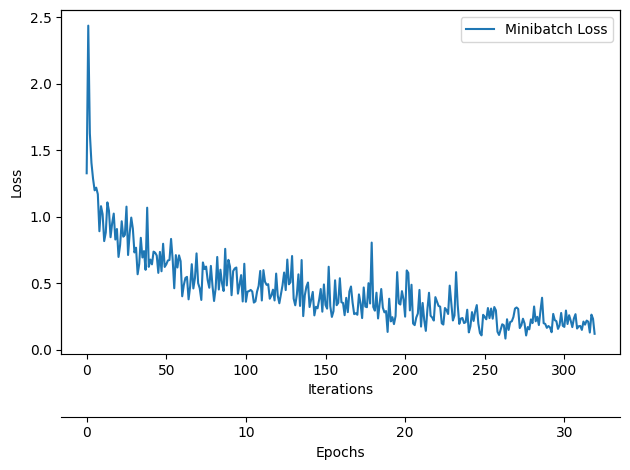

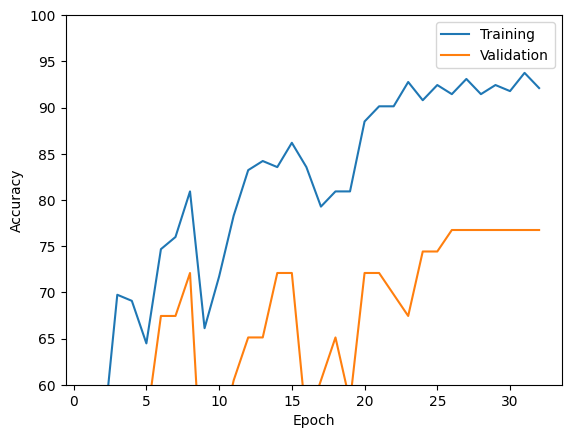

In [111]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=model_path,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=model_path)
plt.ylim([60, 100])
plt.show()

## Model 2 "3D" Resnet

In [11]:
def compute_accuracy_test(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):
            # print(features[0,:,:,:].transpose(0,1).transpose(1,2).shape)
            # plt.imshow(features[0,:,:,:].transpose(0,1).transpose(1,2))
            # plt.show()
            features = features.repeat(1,3,1,1)
            features = features.to(device)
            # torch.set_printoptions(precision=3)
            # torch.set_printoptions(threshold=float("inf"))
            
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            # print(a, predicted_labels)
            # print(targets, predicted_labels)
            print(i)
            break
            # num_examples += targets.size(0)
            # correct_pred += (predicted_labels == targets).sum()
    return # correct_pred.float()/num_examples * 100
compute_accuracy_test(model, val_loader, device)

0


In [9]:
batch_size = 304

data_transform = transforms.Compose([
    transforms.Resize((224,224)),
    # transforms.RandomResizedCrop(224),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize([0.2170], [0.2997])
    # transforms.Normalize([0.1690], [0.2304])
])

out_dir_single = '/scratch/users/neuroimage/conda/data/paired_data/2D_mul'
train_path = os.path.join(out_dir_single, 'train', 'wm')
train_dataset = datasets.ImageFolder(train_path, transform=data_transform, loader=tiff_loader)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

val_path = os.path.join(out_dir_single, 'val', 'wm')
val_dataset = datasets.ImageFolder(val_path, transform=data_transform, loader=tiff_loader)
val_loader = torch.utils.data.DataLoader(val_dataset,  shuffle=True)

test_path = os.path.join(out_dir_single, 'test', 'wm')
test_dataset = datasets.ImageFolder(test_path, transform=data_transform, loader=tiff_loader)
test_loader = torch.utils.data.DataLoader(test_dataset,  shuffle=True)

In [68]:
len(train_dataset.imgs)

12160

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# resnet
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
for param in model.parameters():
    param.requires_grad = False
# model
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes), bias=True)

model.fc.requires_grad = True

model = model.to(device)

criterion = nn.CrossEntropyLoss()

In [74]:
def train_model(model, num_epochs, train_loader,
                valid_loader, test_loader, optimizer,
                device, logging_interval=50,
                scheduler=None,
                scheduler_on='valid_acc', model_path = None, save_interval = 10, timestamp = None):

    start_time = time.time()
    minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []
    
    for epoch in tqdm(range(num_epochs)):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):
            features = features.repeat(1,3,1,1).to(device)
            targets = targets.to(device)

            # ## FORWARD AND BACK PROP
            logits = model(features)
            loss = torch.nn.functional.cross_entropy(logits, targets)
            optimizer.zero_grad()

            loss.backward()

            # ## UPDATE MODEL PARAMETERS
            optimizer.step()
            # print(model.fc.weight.grad)

            # ## LOGGING
            minibatch_loss_list.append(loss.item())
            if not batch_idx % logging_interval:
                print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                      f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                      f'| Loss: {loss:.4f}')

        model.eval()
        with torch.no_grad():  # save memory during inference
            train_acc = compute_accuracy(model, train_loader, device=device)
            valid_acc = compute_accuracy(model, valid_loader, device=device)
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                  f'| Train: {train_acc :.2f}% '
                  f'| Validation: {valid_acc :.2f}%')
            train_acc_list.append(train_acc.item())
            valid_acc_list.append(valid_acc.item())

        elapsed = (time.time() - start_time)/60
        print(f'Time elapsed: {elapsed:.2f} min')
        
        if scheduler is not None:

            if scheduler_on == 'valid_acc':
                scheduler.step(valid_acc_list[-1])
            elif scheduler_on == 'minibatch_loss':
                scheduler.step(minibatch_loss_list[-1])
            else:
                raise ValueError(f'Invalid `scheduler_on` choice.')
        
        if epoch % save_interval == 0 and epoch > 10:
            model_prefix = "resnet50_3D"
            model_name = f"{model_prefix}_{timestamp}_epoch{epoch}.pth"
            torch.save(model.state_dict(), os.path.join(model_path, model_name))
            test_acc = compute_accuracy(model, test_loader, device=device)
            print(f'Test accuracy {test_acc :.2f}%')
            

    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')

    test_acc = compute_accuracy(model, test_loader, device=device)
    print(f'Test accuracy {test_acc :.2f}%')

    return minibatch_loss_list, train_acc_list, valid_acc_list

In [75]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

NUM_EPOCHS = 50
model_dir = model_path
model_prefix = "resnet50_3D"

from datetime import datetime
timestamp = datetime.now().strftime("%m%d%H%M")
model_name_path = f"{model_prefix}_{timestamp}"
model_path = os.path.join(model_dir, model_prefix + '_wd0.0002', model_name_path)

if not os.path.exists(model_path):
    os.makedirs(model_path)


minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=val_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=1,  model_path = model_path, save_interval = 5, timestamp = timestamp)

  0%|          | 0/50 [02:00<?, ?it/s]


KeyboardInterrupt: 

## Some analysis(explainable AI)

In [7]:
batch_size = 1

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomResizedCrop(224),
    # transforms.ColorJitter(contrast=0.4),
    transforms.ElasticTransform(alpha=70.0, sigma=7.0),
    transforms.ToTensor(),
    transforms.Normalize([0.2170], [0.2997])  # wm
    # transforms.Normalize([0.1690], [0.2304]) # gm
])
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.2170], [0.2997])  # wm
    # transforms.Normalize([0.1690], [0.2304]) # gm
])

out_dir_single = '/scratch/users/neuroimage/conda/data/paired_data/2D_single'
train_path = os.path.join(out_dir_single, 'train', 'wm')
train_dataset = datasets.ImageFolder(train_path, transform=train_transform, loader=tiff_loader)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

val_path = os.path.join(out_dir_single, 'val', 'wm')
val_dataset = datasets.ImageFolder(val_path, transform=test_transform, loader=tiff_loader)
val_loader = torch.utils.data.DataLoader(val_dataset,  shuffle=True)

test_path = os.path.join(out_dir_single, 'test', 'wm')
test_dataset = datasets.ImageFolder(test_path, transform=test_transform, loader=tiff_loader)
test_loader = torch.utils.data.DataLoader(test_dataset,  shuffle=True)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# resnet
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes), bias=True)

# path = model_dir + "/resnet50_wd0.001_normalize/resnet50_05012343/resnet50_05012343_epoch32.pth"
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
path = "/scratch/users/neuroimage/conda/data/models/resnet50_wd0.001_normalize_layer34_lr0.0005_aug/resnet50_05030801/resnet50_05030801_epoch4.pth"
model.load_state_dict(torch.load(path))
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
model.eval()
test_acc = compute_accuracy(model, test_loader, device=device, repeat=False)
print(f'Test accuracy {test_acc :.2f}%')

val_acc = compute_accuracy(model, val_loader, device=device, repeat=False)
print(f'Val accuracy {val_acc :.2f}%')

Test accuracy 94.25%
Val accuracy 88.37%


In [9]:
import matplotlib.pyplot as plt
from torch.autograd import Function
from torchvision import models
from torchvision import utils
import cv2
import sys
from collections import OrderedDict
import numpy as np
import argparse
import os
import torch.nn as nn

In [10]:
model.eval()
import copy
resnet = copy.deepcopy(model)

In [12]:
i=0##testing in what
image = []
class FeatureExtractor():
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers """
    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():##resnet50没有.feature这个特征，直接删除用就可以。
            x = module(x)
            #print('name=',name)
            #print('x.size()=',x.size())
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
            #print('outputs.size()=',x.size())
        #print('len(outputs)',len(outputs))
        return outputs, x

class ModelOutputs():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermeddiate targetted layers. """
    def __init__(self, model, target_layers,use_cuda):
        self.model = model
        self.feature_extractor = FeatureExtractor(self.model, target_layers)
        self.cuda = use_cuda
    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations, output  = self.feature_extractor(x)
        output = output.view(output.size(0), -1)
        #print('classfier=',output.size())
        if self.cuda:
            output = output.cpu()
            output = resnet.fc(output).cuda()##这里就是为什么我们多加载一个resnet模型进来的原因，因为后面我们命名的model不包含fc层，但是这里又偏偏要使用。#
        else:
            output = resnet.fc(output)##这里对应use-cuda上更正一些bug,不然用use-cuda的时候会导致类型对不上,这样保证既可以在cpu上运行,gpu上运行也不会出问题.
        return target_activations, output


class GradCam:
    def __init__(self, model, target_layer_names, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, target_layer_names, use_cuda)

    def forward(self, features):
        return self.model(features) 

    def __call__(self, features, index = None):
        if self.cuda:
            features, output = self.extractor(features.cuda())
        else:
            features, output = self.extractor(features)
        # print(features[0].shape, output[0].shape)
        if index == None:
            index = np.argmax(output.cpu().data.numpy())
        one_hot = np.zeros((1, output.size()[-1]), dtype = np.float32)
        one_hot[0][index] = 1
        one_hot = torch.Tensor(torch.from_numpy(one_hot))
        one_hot.requires_grad = True
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)
        
        self.model.zero_grad()##features和classifier不包含，可以重新加回去试一试，会报错不包含这个对象。
        #self.model.zero_grad()
        one_hot.backward(retain_graph=True)##这里适配我们的torch0.4及以上，我用的1.0也可以完美兼容。（variable改成graph即可）

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()
        #print('grads_val',grads_val.shape)
        target = features[-1]
        target = target.cpu().data.numpy()[0, :]
        # print(grads_val.shape)
        weights = np.mean(grads_val, axis = (2, 3))[0, :]
        #print('weights',weights.shape)
        cam = np.zeros(target.shape[1 : ], dtype = np.float32)
        #print('cam',cam.shape)
        #print('features',features[-1].shape)
        #print('target',target.shape)
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        # print(cam)
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam
        
class GuidedBackpropReLUModel:
    def __init__(self, model, use_cuda):
        self.model = model#这里同理，要的是一个完整的网络，不然最后维度会不匹配。
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        for module in self.model.named_modules():
            module[1].register_backward_hook(self.bp_relu)

    def bp_relu(self, module, grad_in, grad_out):
        if isinstance(module, nn.ReLU):
            return (torch.clamp(grad_in[0], min=0.0),)
    def forward(self, features):
        return self.model(features)

    def __call__(self, features, index = None):
        if self.cuda:
            output = self.forward(features.cuda())
        else:
            output = self.forward(features)
        if index == None:
            index = np.argmax(output.cpu().data.numpy())
        print(features.grad)
        one_hot = np.zeros((1, output.size()[-1]), dtype = np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot)
        one_hot.requires_grad = True
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)
        #self.model.classifier.zero_grad()
        one_hot.backward(retain_graph=True)
        output = features.grad.cpu().data.numpy()
        output = output[0,:,:,:]
        return output


In [13]:
def show_cam_on_image(img, mask,path,name):
	# plt.imshow(mask, cmap='gray')
	heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
	# print(heatmap)
	heatmap = np.float32(heatmap) / 255
	#plt.imshow(img[0,:,:])

	cam = heatmap + np.float32(img).transpose(1,2,0) # 
	cam = cam / np.max(cam)
	plt.imshow(cam)

	cv2.imwrite(f"{path}/cam_{name}.jpg", 255 * cam)

	heatmap = heatmap / np.max(heatmap)
	cv2.imwrite(f"{path}/heat_{name}.jpg", np.uint8(255 * heatmap))

In [119]:
reversed_dict = {value: key for key, value in test_dataset.class_to_idx.items()}
reversed_dict

{0: 'AD', 1: 'CN', 2: 'MCI'}

In [14]:
""" python grad_cam.py <path_to_image>
1. Loads an image with opencv.
2. Preprocesses it for VGG19 and converts to a pytorch variable.
3. Makes a forward pass to find the category index with the highest score,
and computes intermediate activations.
Makes the visualization. """


# Can work with any model, but it assumes that the model has a 
# feature method, and a classifier method,
# as in the VGG models in torchvision.
# del model.fc

#print(model)
grad_cam = GradCam(model, target_layer_names = ["layer4"], use_cuda=False)

data_loader = train_loader

resnet.eval()

for i, (features, targets) in enumerate(data_loader):
	features.required_grad = True
	# print('input.size()=',features.size())

	target_index =None
	mask = grad_cam(features, None)
	i=i+1 
	img = features.repeat(1,3,1,1).squeeze()
	output = resnet(features)
	index = np.argmax(output.cpu().data.numpy())
	path = f'train_cam/{reversed_dict[targets[0].item()]}/{reversed_dict[index]}/'
	if not os.path.exists(path):
		os.makedirs(path)
	# print(path)
	# break
	show_cam_on_image(img, mask, path, i)
	# gb_model = GuidedBackpropReLUModel(model = copy.deepcopy(resnet), use_cuda=False)
	# gb = gb_model(features, index=target_index)
	# if not os.path.exists('gb'):
	# 	os.mkdir('gb')
	# if not os.path.exists('camgb'):
	# 	os.mkdir('camgb')
	# utils.save_image(torch.from_numpy(gb), 'gb/gb_{}.jpg'.format(i))
	# cam_mask = np.zeros(gb.shape)
	# for j in range(0, gb.shape[0]):
	# 	cam_mask[j, :, :] = mask
	# cam_gb = np.multiply(cam_mask, gb)
	# utils.save_image(torch.from_numpy(cam_gb), 'camgb/cam_gb_{}.jpg'.format(i))
	# break

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2048x1 and 2048x3)

In [48]:
np.float32(img).transpose(1,2,0).shape

(224, 224, 3)